#### ***Import Libraries***

# Bloque 1: Configuración e Importación de Librerías

En este bloque se importan las principales librerías que usaremos a lo largo del notebook:
- **Numpy y Pandas:** Para manipulación de datos.
- **Matplotlib:** Para las visualizaciones.
- **PyTorch:** Para definir y entrenar el modelo de recomendación.
- **Scikit-learn:** Para la división de datos y el cálculo de métricas.

Además, se configura el dispositivo de cómputo, utilizando GPU si está disponible.

In [1]:
# Bloque 1: Configuración e Importación de Librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configurar el dispositivo: usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# Bloque 2: Carga y Preprocesamiento de Datos

En este bloque se realiza la carga del archivo `ratings.dat` y se aplica el preprocesamiento:
- Se filtran usuarios y películas con al menos 5 ratings.
- Se convierte el timestamp a formato datetime y se extraen características temporales (año, mes y día de la semana).
- Se normalizan los ratings dividiéndolos por 5 para que queden en el rango [0,1].

In [2]:
# Bloque 2: Carga y Preprocesamiento de Datos

# Cargar el dataset de ratings (asegúrate de que el archivo "ratings.dat" esté en el directorio actual o ajusta la ruta)
ratings = pd.read_csv("../data/ml-1m/ml-1m/ratings.dat", sep="::", engine="python", 
                        header=None, names=["UserID", "MovieID", "Rating", "Timestamp"])

# Mostrar las primeras filas y las dimensiones del dataset
print("Primeras 5 filas:")
print(ratings.head())
print("\nDimensiones del dataset:", ratings.shape)

# Filtrar usuarios con al menos 5 ratings
user_counts = ratings['UserID'].value_counts()
ratings = ratings[ratings['UserID'].isin(user_counts[user_counts >= 5].index)]

# Filtrar películas con al menos 5 ratings
movie_counts = ratings['MovieID'].value_counts()
ratings = ratings[ratings['MovieID'].isin(movie_counts[movie_counts >= 5].index)]

print("\nUsuarios después de filtrar:", ratings['UserID'].nunique())
print("Películas después de filtrar:", ratings['MovieID'].nunique())

# Convertir Timestamp a datetime y extraer características temporales
ratings['Datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')
ratings['Year'] = ratings['Datetime'].dt.year
ratings['Month'] = ratings['Datetime'].dt.month
ratings['DayOfWeek'] = ratings['Datetime'].dt.dayofweek

# Normalizar los ratings a [0,1]
ratings['Rating_Norm'] = ratings['Rating'] / 5.0

# Mostrar un resumen del preprocesamiento
print("\nResumen del preprocesamiento:")
print(ratings[['UserID', 'MovieID', 'Rating', 'Rating_Norm', 'Datetime', 'Year', 'Month', 'DayOfWeek']].head())

Primeras 5 filas:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Dimensiones del dataset: (1000209, 4)

Usuarios después de filtrar: 6040
Películas después de filtrar: 3416

Resumen del preprocesamiento:
   UserID  MovieID  Rating  Rating_Norm            Datetime  Year  Month  \
0       1     1193       5          1.0 2000-12-31 22:12:40  2000     12   
1       1      661       3          0.6 2000-12-31 22:35:09  2000     12   
2       1      914       3          0.6 2000-12-31 22:32:48  2000     12   
3       1     3408       4          0.8 2000-12-31 22:04:35  2000     12   
4       1     2355       5          1.0 2001-01-06 23:38:11  2001      1   

   DayOfWeek  
0          6  
1          6  
2          6  
3          6  
4          5  


# Bloque 2.1: Carga y Preprocesamiento de Datos Adicionales

En este bloque cargaremos y preprocesaremos los archivos `users.dat` y `movies.dat`:
- **users.dat:** Contiene información sobre el usuario (UserID, Gender, Age, Occupation, Zip-code).  
  Se procesarán las variables:
  - *Gender*: se codifica como 0 para "F" y 1 para "M".
  - *Age* y *Occupation*: se dejan como numéricas (o se pueden transformar en categorías para generar embeddings más adelante).
  
- **movies.dat:** Contiene la información de las películas (MovieID, Title, Genres).  
  Se procesará la columna *Genres*:
  - Se separan los géneros (que vienen separados por el símbolo "|") para obtener una lista de géneros por película.
  - Se genera un mapeo de cada género a un índice para usarlo posteriormente en embeddings o en una codificación multi-hot.

In [6]:
# Bloque 2.1: Carga y Preprocesamiento de Datos Adicionales (users.dat y movies.dat)

# Cargar users.dat
users = pd.read_csv("../data/ml-1m/ml-1m/users.dat", sep="::", engine="python", header=None, 
                    names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])
print("Usuarios - Primeras filas:")
print(users.head())

# Procesar users.dat
# Codificar Gender: F -> 0, M -> 1
users["Gender"] = users["Gender"].map({"F": 0, "M": 1})
# Convertir Age y Occupation a enteros (ya vienen como enteros en este dataset)
users["Age"] = users["Age"].astype(int)
users["Occupation"] = users["Occupation"].astype(int)
print("\nUsuarios procesados:")
print(users.head())

# Cargar movies.dat
movies = pd.read_csv("../data/ml-1m/ml-1m/movies.dat", sep="::", engine="python", header=None, 
                     names=["MovieID", "Title", "Genres"], encoding="latin-1")
print("\nPelículas - Primeras filas:")
print(movies.head())

# Procesar movies.dat
# Separar la columna 'Genres' en una lista de géneros para cada película
movies["Genres_list"] = movies["Genres"].apply(lambda x: x.split("|"))
print("\nPelículas con lista de géneros:")
print(movies.head())

# Crear un mapeo de género a índice
all_genres = set()
for genres in movies["Genres_list"]:
    all_genres.update(genres)
all_genres = sorted(list(all_genres))
genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}
print("\nMapa de Géneros a Índice:")
print(genre_to_index)

# Para cada película, convertir la lista de géneros a una lista de índices
movies["Genres_indices"] = movies["Genres_list"].apply(lambda gs: [genre_to_index[g] for g in gs])
print("\nPelículas con índices de géneros:")
print(movies.head())

Usuarios - Primeras filas:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

Usuarios procesados:
   UserID  Gender  Age  Occupation Zip-code
0       1       0    1          10    48067
1       2       1   56          16    70072
2       3       1   25          15    55117
3       4       1   45           7    02460
4       5       1   25          20    55455

Películas - Primeras filas:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Fat

# Bloque 3: Fusión de Datos

En este bloque fusionamos la información de:
- **ratings.dat:** Contiene las interacciones (UserID, MovieID, Rating, Timestamp, etc.).
- **users.dat:** Información de los usuarios (Gender, Age, Occupation, Zip-code).
- **movies.dat:** Información de las películas (Title, lista de géneros y sus índices).

El resultado es un DataFrame en el que cada registro de rating incluye las características adicionales tanto del usuario como de la película.

In [7]:
# Bloque 3: Fusión de Datos

# Fusionar ratings con users utilizando 'UserID'
ratings_merged = ratings.merge(users, on="UserID", how="left")

# Fusionar el resultado con movies utilizando 'MovieID'
# Seleccionamos solo las columnas relevantes de movies
ratings_merged = ratings_merged.merge(movies[['MovieID', 'Title', 'Genres_list', 'Genres_indices']], on="MovieID", how="left")

print("Dimensiones del DataFrame fusionado:", ratings_merged.shape)
print("Primeras filas del DataFrame fusionado:")
print(ratings_merged.head())

Dimensiones del DataFrame fusionado: (999611, 16)
Primeras filas del DataFrame fusionado:
   UserID  MovieID  Rating  Timestamp            Datetime  Year  Month  \
0       1     1193       5  978300760 2000-12-31 22:12:40  2000     12   
1       1      661       3  978302109 2000-12-31 22:35:09  2000     12   
2       1      914       3  978301968 2000-12-31 22:32:48  2000     12   
3       1     3408       4  978300275 2000-12-31 22:04:35  2000     12   
4       1     2355       5  978824291 2001-01-06 23:38:11  2001      1   

   DayOfWeek  Rating_Norm  Gender  Age  Occupation Zip-code  \
0          6          1.0       0    1          10    48067   
1          6          0.6       0    1          10    48067   
2          6          0.6       0    1          10    48067   
3          6          0.8       0    1          10    48067   
4          5          1.0       0    1          10    48067   

                                    Title                       Genres_list  \
0  One 

# Bloque 4: Creación del Dataset Personalizado y DataLoaders (Actualizado)

En este bloque actualizaremos la clase de Dataset para incluir las nuevas características:
- Se generan índices numéricos para usuarios y películas.
- Se crea una representación multi-hot para los géneros de las películas.
- Se retorna, para cada muestra, no solo el rating y los índices, sino también:
  - `user_features`: [Gender, Age, Occupation].
  - `movie_features`: vector multi-hot de géneros.

Finalmente, se crean los DataLoaders para entrenamiento, validación y test.

In [8]:
import numpy as np

# 1. Asegurar la existencia de índices para usuarios y películas usando factorize
if 'userIndex' not in ratings_merged.columns:
    ratings_merged['userIndex'] = pd.factorize(ratings_merged['UserID'])[0]
if 'movieIndex' not in ratings_merged.columns:
    ratings_merged['movieIndex'] = pd.factorize(ratings_merged['MovieID'])[0]

# Verificar rangos:
print("UserIndex: min =", ratings_merged['userIndex'].min(), "max =", ratings_merged['userIndex'].max())
print("MovieIndex: min =", ratings_merged['movieIndex'].min(), "max =", ratings_merged['movieIndex'].max())

# 2. Crear la representación multi-hot para géneros
n_genres = len(genre_to_index)
def create_multi_hot(indices):
    vec = np.zeros(n_genres, dtype=int)
    for idx in indices:
        vec[idx] = 1
    return vec.tolist()

ratings_merged['Genres_multi_hot'] = ratings_merged['Genres_indices'].apply(create_multi_hot)
print("\nEjemplo de Genres_multi_hot:")
print(ratings_merged[['MovieID', 'Genres_indices', 'Genres_multi_hot']].head())

# 3. Definir la clase Dataset actualizada
from torch.utils.data import Dataset, DataLoader
import torch

class MovieLensEnhancedDataset(Dataset):
    def __init__(self, data):
        # Extraer índices y rating normalizado
        self.users = torch.tensor(data['userIndex'].values, dtype=torch.long)
        self.movies = torch.tensor(data['movieIndex'].values, dtype=torch.long)
        self.ratings = torch.tensor(data['Rating_Norm'].values, dtype=torch.float32)
        
        # Extraer características del usuario: Gender, Age, Occupation
        # Convertimos a tensor de tipo float (podrías normalizar Age si lo consideras necesario)
        self.user_features = torch.tensor(data[['Gender', 'Age', 'Occupation']].values, dtype=torch.float32)
        
        # Extraer características de la película: vector multi-hot de géneros
        # Convertimos cada lista a tensor y luego apilamos (esto se hace en el __getitem__)
        self.movie_features = data['Genres_multi_hot'].values  # Mantendremos las listas, para procesarlas en __getitem__
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        # Convertir la lista de multi-hot a tensor
        movie_feat = torch.tensor(self.movie_features[idx], dtype=torch.float32)
        return {
            "user": self.users[idx],
            "movie": self.movies[idx],
            "rating": self.ratings[idx],
            "user_features": self.user_features[idx],
            "movie_features": movie_feat
        }

# Dividir de nuevo los datos en conjuntos de entrenamiento, validación y test.
# Asumimos que previamente se hizo la división por usuario.
# Si no se ha realizado, se puede realizar una división similar a la utilizada anteriormente.
# Aquí usaremos los DataFrames train_data, val_data y test_data generados previamente.
# Es importante que estos DataFrames provengan del DataFrame fusionado: ratings_merged.
# Para este ejemplo, los redefiniremos usando una división simple por usuario.
from sklearn.model_selection import train_test_split

# Para garantizar que cada usuario tenga suficientes ratings, usamos el DataFrame fusionado completo
# y dividimos por usuario de forma similar a como se hizo antes.
train_list, val_list, test_list = [], [], []
for user_id, group in ratings_merged.groupby("UserID"):
    group = group.sort_values("Timestamp")
    train, temp = train_test_split(group, test_size=0.30, random_state=42)
    val, test = train_test_split(temp, test_size=0.50, random_state=42)
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

print("Tamaño de train_df:", train_df.shape)
print("Tamaño de val_df:", val_df.shape)
print("Tamaño de test_df:", test_df.shape)

# Crear instancias de los datasets
train_dataset_enh = MovieLensEnhancedDataset(train_df)
val_dataset_enh = MovieLensEnhancedDataset(val_df)
test_dataset_enh = MovieLensEnhancedDataset(test_df)

# Crear DataLoaders
batch_size = 512
train_loader_enh = DataLoader(train_dataset_enh, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_enh = DataLoader(val_dataset_enh, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_enh = DataLoader(test_dataset_enh, batch_size=batch_size, shuffle=False, num_workers=0)

print("Tamaño del dataset de entrenamiento (enhanced):", len(train_dataset_enh))
print("Tamaño del dataset de validación (enhanced):", len(val_dataset_enh))
print("Tamaño del dataset de test (enhanced):", len(test_dataset_enh))

UserIndex: min = 0 max = 6039
MovieIndex: min = 0 max = 3415

Ejemplo de Genres_multi_hot:
   MovieID Genres_indices                                   Genres_multi_hot
0     1193            [7]  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
1      661     [2, 3, 11]  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
2      914       [11, 13]  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...
3     3408            [7]  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
4     2355      [2, 3, 4]  [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Tamaño de train_df: (697017, 19)
Tamaño de val_df: (149779, 19)
Tamaño de test_df: (152815, 19)
Tamaño del dataset de entrenamiento (enhanced): 697017
Tamaño del dataset de validación (enhanced): 149779
Tamaño del dataset de test (enhanced): 152815


# Bloque 5: Definición del Modelo Mejorado (Integrando Datos Adicionales)

En este bloque definimos un modelo que, además de utilizar los índices de usuario y película, incorpora:
- **Características del usuario:** [Gender, Age, Occupation].  
- **Características de la película:** Representación multi-hot de géneros.

La arquitectura consiste en:
1. Obtener embeddings para el ID de usuario y de película.
2. Transformar las características adicionales mediante capas lineales.
3. Combinar (concatenar) las representaciones y pasarlas por una red MLP para obtener la predicción final.

In [9]:
import torch.nn as nn
import torch

class NeuMFEnhanced(nn.Module):
    def __init__(self, num_users, num_movies, num_genres,
                 user_embedding_dim=32, movie_embedding_dim=32,
                 user_feature_dim=3, movie_feature_output_dim=16,
                 mlp_layers=[128, 64], dropout=0.3):
        super(NeuMFEnhanced, self).__init__()
        
        # Embeddings para IDs de usuario y película
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, movie_embedding_dim)
        
        # Transformación de características adicionales
        # Para usuarios: transformar [Gender, Age, Occupation] a un vector del mismo tamaño que user_embedding_dim.
        self.user_feat_fc = nn.Linear(user_feature_dim, user_embedding_dim)
        # Para películas: transformar el vector multi-hot de géneros (tamaño=num_genres) a un vector de tamaño movie_feature_output_dim.
        self.movie_feat_fc = nn.Linear(num_genres, movie_feature_output_dim)
        
        # Después de combinar:
        # Usuario combinado: embedding (user_embedding_dim) + user extra (user_embedding_dim) = 2 * user_embedding_dim.
        # Película combinada: embedding (movie_embedding_dim) + movie extra (movie_feature_output_dim).
        fusion_input_dim = (user_embedding_dim * 2) + (movie_embedding_dim + movie_feature_output_dim)
        
        # Red MLP para fusionar ambas representaciones
        self.fusion_fc1 = nn.Linear(fusion_input_dim, mlp_layers[0])
        self.bn1 = nn.BatchNorm1d(mlp_layers[0])
        self.fusion_fc2 = nn.Linear(mlp_layers[0], mlp_layers[1])
        self.bn2 = nn.BatchNorm1d(mlp_layers[1])
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(mlp_layers[1], 1)
    
    def forward(self, user_id, movie_id, user_features, movie_features):
        # Obtener embeddings
        user_emb = self.user_embedding(user_id)            # (batch, user_embedding_dim)
        movie_emb = self.movie_embedding(movie_id)          # (batch, movie_embedding_dim)
        
        # Procesar características adicionales
        user_extra = self.user_feat_fc(user_features)       # (batch, user_embedding_dim)
        movie_extra = self.movie_feat_fc(movie_features)    # (batch, movie_feature_output_dim)
        
        # Combinar por concatenación
        user_combined = torch.cat([user_emb, user_extra], dim=1)  # (batch, 2 * user_embedding_dim)
        movie_combined = torch.cat([movie_emb, movie_extra], dim=1) # (batch, movie_embedding_dim + movie_feature_output_dim)
        
        fusion_input = torch.cat([user_combined, movie_combined], dim=1)  # (batch, fusion_input_dim)
        
        x = self.fusion_fc1(fusion_input)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.fusion_fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        out = self.output(x)
        return out.squeeze()

# Inicialización del modelo mejorado
num_users = train_df['userIndex'].max() + 1    # 6040
num_movies = train_df['movieIndex'].max() + 1    # 3416
num_genres = len(genre_to_index)                 # 18, según nuestro mapeo

model_enhanced = NeuMFEnhanced(num_users=num_users,
                               num_movies=num_movies,
                               num_genres=num_genres,
                               user_embedding_dim=32,
                               movie_embedding_dim=32,
                               user_feature_dim=3,
                               movie_feature_output_dim=16,
                               mlp_layers=[128, 64],
                               dropout=0.3)
model_enhanced = model_enhanced.to(device)
print(model_enhanced)

NeuMFEnhanced(
  (user_embedding): Embedding(6040, 32)
  (movie_embedding): Embedding(3416, 32)
  (user_feat_fc): Linear(in_features=3, out_features=32, bias=True)
  (movie_feat_fc): Linear(in_features=18, out_features=16, bias=True)
  (fusion_fc1): Linear(in_features=112, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fusion_fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


# Bloque 6: Entrenamiento del Modelo Mejorado

En este bloque entrenaremos el modelo mejorado (NeuMFEnhanced) usando el dataset enriquecido (train_loader_enh, val_loader_enh y test_loader_enh).  
Se usará una función de pérdida MSE, el optimizador Adam y un scheduler para reducir la tasa de aprendizaje en caso de que la pérdida de validación no mejore.  
Implementaremos early stopping basado en la pérdida de validación para evitar sobreentrenamiento.

In [10]:
# Bloque 6: Entrenamiento del Modelo Mejorado

num_epochs_enh = 30
criterion_enh = nn.MSELoss()
optimizer_enh = optim.Adam(model_enhanced.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_enh = optim.lr_scheduler.ReduceLROnPlateau(optimizer_enh, mode='min', factor=0.5, patience=2)

best_val_loss_enh = float('inf')
early_stopping_counter_enh = 0
patience_enh = 5

train_losses_enh = []
val_losses_enh = []

for epoch in range(num_epochs_enh):
    model_enhanced.train()
    running_train_loss = 0.0
    for batch in train_loader_enh:
        # Extraer datos y moverlos a dispositivo
        users = batch["user"].to(device)
        movies = batch["movie"].to(device)
        ratings_batch = batch["rating"].to(device)
        user_features = batch["user_features"].to(device)
        movie_features = batch["movie_features"].to(device)
        
        # Forward: pasamos todos los inputs al modelo
        preds = model_enhanced(users, movies, user_features, movie_features)
        loss = criterion_enh(preds, ratings_batch)
        
        optimizer_enh.zero_grad()
        loss.backward()
        optimizer_enh.step()
        
        running_train_loss += loss.item() * len(ratings_batch)
    
    avg_train_loss = running_train_loss / len(train_dataset_enh)
    train_losses_enh.append(avg_train_loss)
    
    # Validación
    model_enhanced.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader_enh:
            users = batch["user"].to(device)
            movies = batch["movie"].to(device)
            ratings_batch = batch["rating"].to(device)
            user_features = batch["user_features"].to(device)
            movie_features = batch["movie_features"].to(device)
            
            preds = model_enhanced(users, movies, user_features, movie_features)
            loss = criterion_enh(preds, ratings_batch)
            running_val_loss += loss.item() * len(ratings_batch)
    
    avg_val_loss = running_val_loss / len(val_dataset_enh)
    val_losses_enh.append(avg_val_loss)
    
    scheduler_enh.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs_enh} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss_enh:
        best_val_loss_enh = avg_val_loss
        early_stopping_counter_enh = 0
        torch.save(model_enhanced.state_dict(), "best_model_enhanced.pth")
    else:
        early_stopping_counter_enh += 1
        if early_stopping_counter_enh >= patience_enh:
            print("Early stopping activado.")
            break

print("Entrenamiento del modelo mejorado completado.")

Epoch 1/30 - Train Loss: 0.0684 - Val Loss: 0.0480
Epoch 2/30 - Train Loss: 0.0397 - Val Loss: 0.0374
Epoch 3/30 - Train Loss: 0.0361 - Val Loss: 0.0361
Epoch 4/30 - Train Loss: 0.0354 - Val Loss: 0.0341
Epoch 5/30 - Train Loss: 0.0350 - Val Loss: 0.0354
Epoch 6/30 - Train Loss: 0.0346 - Val Loss: 0.0336
Epoch 7/30 - Train Loss: 0.0343 - Val Loss: 0.0339
Epoch 8/30 - Train Loss: 0.0338 - Val Loss: 0.0327
Epoch 9/30 - Train Loss: 0.0331 - Val Loss: 0.0320
Epoch 10/30 - Train Loss: 0.0324 - Val Loss: 0.0316
Epoch 11/30 - Train Loss: 0.0317 - Val Loss: 0.0311
Epoch 12/30 - Train Loss: 0.0313 - Val Loss: 0.0308
Epoch 13/30 - Train Loss: 0.0309 - Val Loss: 0.0306
Epoch 14/30 - Train Loss: 0.0305 - Val Loss: 0.0305
Epoch 15/30 - Train Loss: 0.0303 - Val Loss: 0.0303
Epoch 16/30 - Train Loss: 0.0301 - Val Loss: 0.0303
Epoch 17/30 - Train Loss: 0.0299 - Val Loss: 0.0301
Epoch 18/30 - Train Loss: 0.0296 - Val Loss: 0.0299
Epoch 19/30 - Train Loss: 0.0294 - Val Loss: 0.0299
Epoch 20/30 - Train L

# Bloque 7: Evaluación y Visualización del Modelo Mejorado

En este bloque se realiza lo siguiente:
- Se carga el mejor modelo mejorado ("best_model_enhanced.pth").
- Se evalúa en el conjunto de test (test_loader_enh) para calcular las métricas de regresión: RMSE, MAE y R².
- Se generan visualizaciones para analizar el desempeño del modelo:
  - Scatter Plot: comparación entre predicciones y valores reales.
  - Histograma de errores.
  - Residual Plot: errores en función de las predicciones.

In [11]:
# Bloque 7: Evaluación y Visualización del Modelo Mejorado

# Cargar el modelo mejorado guardado
model_enhanced.load_state_dict(torch.load("best_model_enhanced.pth", map_location=device))
model_enhanced.eval()

# Evaluar en el conjunto de test enriquecido
y_true_enh = []
y_pred_enh = []

with torch.no_grad():
    for batch in test_loader_enh:
        users = batch["user"].to(device)
        movies = batch["movie"].to(device)
        ratings_batch = batch["rating"].to(device)
        user_features = batch["user_features"].to(device)
        movie_features = batch["movie_features"].to(device)
        
        preds = model_enhanced(users, movies, user_features, movie_features)
        y_true_enh.extend(ratings_batch.cpu().numpy())
        y_pred_enh.extend(preds.cpu().numpy())

y_true_enh = np.array(y_true_enh)
y_pred_enh = np.array(y_pred_enh)

# Calcular métricas de regresión
rmse_enh = np.sqrt(mean_squared_error(y_true_enh, y_pred_enh))
mae_enh = mean_absolute_error(y_true_enh, y_pred_enh)
r2_enh = r2_score(y_true_enh, y_pred_enh)

print("Evaluación del Modelo Mejorado en el conjunto de test:")
print(f"RMSE: {rmse_enh:.4f}")
print(f"MAE: {mae_enh:.4f}")
print(f"R²: {r2_enh:.4f}")

Evaluación del Modelo Mejorado en el conjunto de test:
RMSE: 0.1718
MAE: 0.1346
R²: 0.4063


In [16]:
from collections import defaultdict
import numpy as np

# Definir k
k = 10

# Diccionarios para almacenar las predicciones y verdades por usuario
user_preds_enh = defaultdict(list)
user_truth_enh = defaultdict(list)

model_enhanced.eval()
with torch.no_grad():
    for batch in test_loader_enh:
        users = batch["user"].to(device)
        movies = batch["movie"].to(device)
        ratings_batch = batch["rating"].to(device)
        user_features = batch["user_features"].to(device)
        movie_features = batch["movie_features"].to(device)
        
        preds = model_enhanced(users, movies, user_features, movie_features)
        
        # Agrupar las predicciones y valores reales por usuario
        for u, pred, true in zip(users.cpu().numpy(), preds.cpu().numpy(), ratings_batch.cpu().numpy()):
            user_preds_enh[u].append(pred)
            user_truth_enh[u].append(true)

# Función para calcular NDCG@k
def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

precisions_enh = []
ndcgs_enh = []

# Para definir qué es relevante, asumimos que ratings normalizados >= 0.8 (equivalente a rating >= 4) son relevantes.
for u in user_preds_enh:
    preds_u = np.array(user_preds_enh[u])
    truths_u = np.array(user_truth_enh[u])
    
    # Definir relevancia: 1 si el rating >= 0.8, 0 en caso contrario.
    relevant = (truths_u >= 0.8).astype(int)
    
    # Ordenar según las predicciones de forma descendente
    top_k_indices = np.argsort(-preds_u)[:k]
    
    precision_u = np.sum(relevant[top_k_indices]) / k
    precisions_enh.append(precision_u)
    
    # Calcular NDCG@k usando la relevancia binaria
    ndcg_u = ndcg_at_k(relevant[top_k_indices], k)
    ndcgs_enh.append(ndcg_u)

precision_at_k_enh = np.mean(precisions_enh)
ndcg_at_k_enh = np.mean(ndcgs_enh)

print(f"Precision@10 (Modelo Mejorado): {precision_at_k_enh:.4f}")
print(f"NDCG@10 (Modelo Mejorado): {ndcg_at_k_enh:.4f}")

Precision@10 (Modelo Mejorado): 0.6506
NDCG@10 (Modelo Mejorado): 0.9338


# Visualización: Evolución del Loss

Este gráfico muestra cómo evolucionaron las pérdidas (loss) en el conjunto de entrenamiento y validación a lo largo de las épocas. Esto nos ayuda a identificar si el modelo converge adecuadamente y si existe sobreajuste.

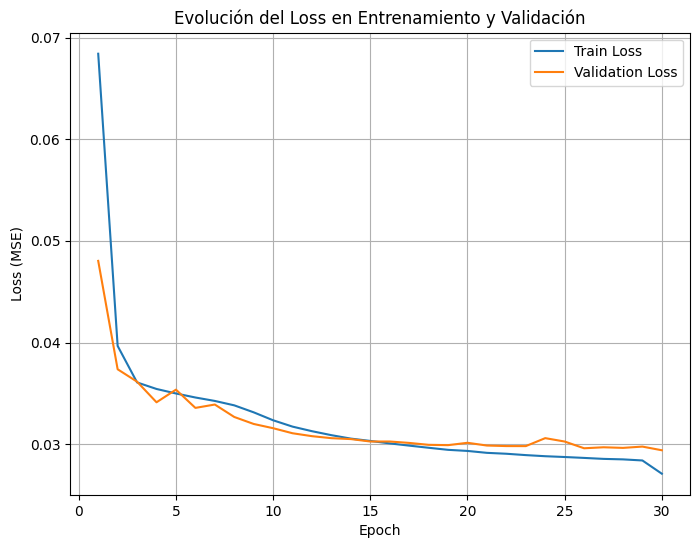

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses_enh)+1), train_losses_enh, label='Train Loss')
plt.plot(range(1, len(val_losses_enh)+1), val_losses_enh, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Evolución del Loss en Entrenamiento y Validación')
plt.legend()
plt.grid(True)
plt.show()

# Visualización 1: Scatter Plot - Predicciones vs. Valores Reales

En este gráfico se representan los ratings reales (en escala [0,5]) frente a las predicciones del modelo. La línea diagonal indica el escenario ideal en el que la predicción es exactamente igual al valor real.

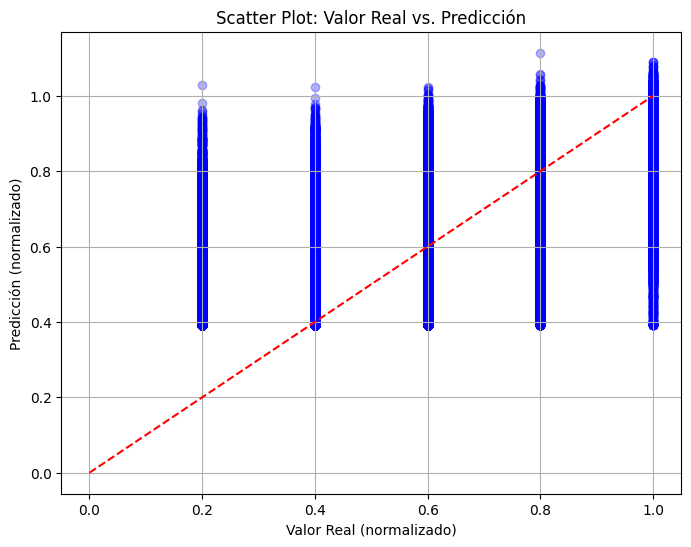

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_true_enh, y_pred_enh, alpha=0.3, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea ideal (y=x)
plt.xlabel("Valor Real (normalizado)")
plt.ylabel("Predicción (normalizado)")
plt.title("Scatter Plot: Valor Real vs. Predicción")
plt.grid(True)
plt.show()

# Visualización 2: Histograma de Errores

Aquí se observa la distribución de los errores (Valor Real - Valor Predicho). Un sesgo hacia la izquierda o derecha o una distribución con colas muy largas puede indicar problemas en la predicción para ciertos rangos.

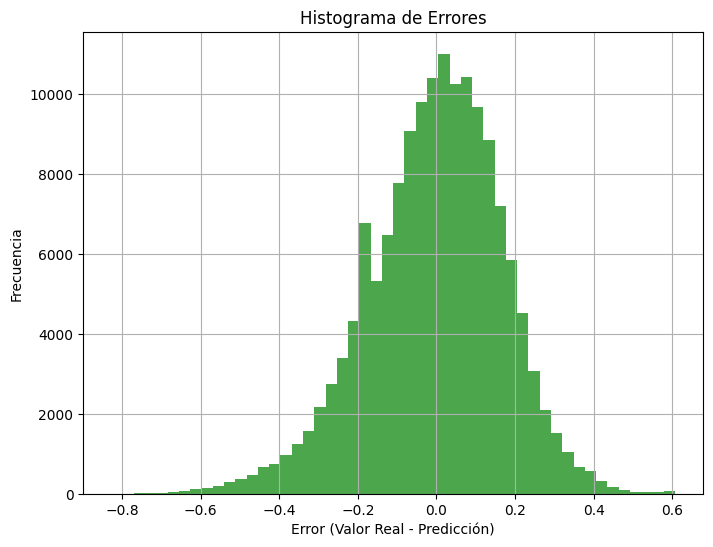

In [14]:
errors_enh = y_true_enh - y_pred_enh

plt.figure(figsize=(8,6))
plt.hist(errors_enh, bins=50, alpha=0.7, color='green')
plt.xlabel("Error (Valor Real - Predicción)")
plt.ylabel("Frecuencia")
plt.title("Histograma de Errores")
plt.grid(True)
plt.show()

# Visualización 3: Residual Plot - Error vs. Predicción

Este plot muestra los residuos (diferencia entre el valor real y el predicho) en función de los valores predichos. La línea horizontal en cero indica el punto en el que la predicción es perfecta. Se busca que los errores estén distribuidos aleatoriamente alrededor de cero.

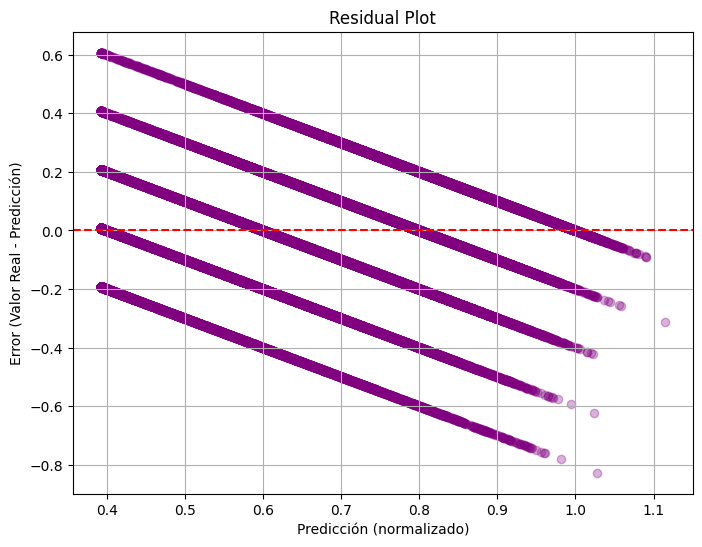

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(y_pred_enh, errors_enh, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción (normalizado)")
plt.ylabel("Error (Valor Real - Predicción)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()